### Sentiment Analysis using Snowflake-snowpark-python

- Import required libraries listed in the below kernel
- You can install the libraries using 
- - pip install <library_name> 
- - python -m pip install <library_name> 

In [1]:
# Import Libraries 

#snowflake-snowpark-python imports 
from snowflake.snowpark.session import Session
from snowflake.snowpark.version import VERSION
from snowflake.snowpark.functions import udtf, lit, table_function
import snowflake.snowpark.types as T
from snowflake.snowpark.types import StructField, StructType, StringType, IntegerType, FloatType, PandasDataFrameType,PandasDataFrame

#nltk and related branches
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re
import json
import boto3
import datetime
import pandas as pd
import numpy as np
import text2emotion as te
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1125)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1125)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1125)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1125)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1125)>


- Use the following script in case below nltk.download fails
- - nltk.download('punkt')
- - nltk.download('stopwords')

***********************************************************************
* import nltk
* import ssl

* try:
*   _create_unverified_https_context = ssl._create_unverified_context
* except AttributeError:
*    pass
* else:
*    ssl._create_default_https_context = _create_unverified_https_context

* nltk.download()
************************************************************************

#### Verify credentials

In [2]:
# Create Snowflake Session object
credentials_file = 'connection_MA.json' # Replace this filename with your credentials filename
connection_parameters = json.load(open(credentials_file))
conn = Session.builder.configs(connection_parameters).create()
conn.sql_simplifier_enabled = True

snowflake_environment = conn.sql('select current_user(), current_role(), current_database(), current_schema(), current_version(), current_warehouse()').collect()
snowpark_version = VERSION

# Current Environment Details
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(snowflake_environment[0][1]))
print('Database                    : {}'.format(snowflake_environment[0][2]))
print('Schema                      : {}'.format(snowflake_environment[0][3]))
print('Warehouse                   : {}'.format(snowflake_environment[0][5]))
print('Snowflake version           : {}'.format(snowflake_environment[0][4]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

User                        : MOHAMMED
Role                        : SE_ROLE
Database                    : GDC_DEMO
Schema                      : PUBLIC
Warehouse                   : SE_DEMO_WH
Snowflake version           : 7.33.1
Snowpark for Python version : 1.6.1


#### Read data from snowflake database

#### UDTFs

In [3]:
# Defining a function
# Reads JSON data from S3 Bucket and converts it to a Pandas Dataframe
def read_json(bucket:str,filename:str)-> T.Variant:
    import boto3
    import json
    import pandas as pd


    s3 = boto3.client(
        's3',
        aws_access_key_id = 'XXXXXXXXXXXXXX',
        aws_secret_access_key = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxx',

    )

    result = s3.get_object(Bucket = bucket, Key = filename) 
    text = result["Body"].read().decode('utf-8')
    json_list = text.strip().split('\n')
    data_dict =[]
    # Process each JSON string
    for json_str in json_list:
        data_dict.append(json.loads(json_str))
    
    json_content_df = pd.DataFrame(data_dict)
    return json_content_df

In [4]:
#Calling a UDTF - result is obtained in the form of a pandas df
# Bucket name = 'thoughtspot-snowpark'
# File names - 'All_Beauty.json', 'meta_All_Beauty.json'
all_beauty_df = read_json("thoughtspot-snowpark", 'All_Beauty.json')
meta_all_beauty_df = read_json("thoughtspot-snowpark", 'meta_All_Beauty.json')


#### Functions to perform analysis on the data

In [5]:
# Define a function to clean the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

analyzer = SentimentIntensityAnalyzer()
# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'
    
# Function to find the matching keyword in the title
def find_matching_keyword(title, keywords):
    if pd.notna(title) and isinstance(title, str):
        title_lower = title.lower()  # Convert title to lowercase for case-insensitive matching
        for keyword in keywords:
            if pd.notna(keyword):
                keyword_words = keyword.lower().split()
                if any(word in title_lower for word in keyword_words):
                    return keyword
    return 'Others'

#### Data cleaning and merging 

In [6]:
# Convert "reviewTime" column to datetime
all_beauty_df["reviewTime"] = pd.to_datetime(all_beauty_df["reviewTime"], format="%m %d, %Y")

# Extract the month and year components and combine them into a new column
all_beauty_df["Date"] = all_beauty_df["reviewTime"].dt.date

# Drop the original "reviewTime" column
all_beauty_df.drop("reviewTime", axis=1, inplace=True)

#merging two datasets
merged_df = pd.merge(all_beauty_df[['overall',"Date", "reviewText","asin"]], meta_all_beauty_df[["title" ,"asin","brand"]], on="asin", how="inner")
df_cleaned = merged_df.drop_duplicates('reviewText', keep=False)

# Drop rows where the "title" column is null
no_duplicates_df = df_cleaned[df_cleaned['title'] != '']
no_duplicates_df = df_cleaned[df_cleaned['brand'] != '']

# Cleaning the text in the review column
no_duplicates_df['Cleaned Reviews'] = no_duplicates_df['reviewText'].apply(clean)
no_duplicates_df = no_duplicates_df.reset_index()
no_duplicates_df.head()


/var/folders/dm/cg0pgfr90sj6zv84qw8pj85w0000gp/T/ipykernel_15341/3420078450.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df['Cleaned Reviews'] = no_duplicates_df['reviewText'].apply(clean)


,index,overall,Date,reviewText,asin,title,brand,Cleaned Reviews
0,0,5.0,2016-03-10,Excellent very good,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,Pirmal Healthcare,Excellent very good
1,2,5.0,2014-10-03,Magical,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,Pirmal Healthcare,Magical
2,4,4.0,2014-06-14,I do like the product a lot...I had bought the...,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,Pirmal Healthcare,I do like the product a lot I had bought them ...
3,5,5.0,2018-03-02,I have OILY skin. I have tried quite a few mat...,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,Pirmal Healthcare,I have OILY skin I have tried quite a few matt...
4,6,1.0,2017-10-05,Got different bottle looks dulpicate,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,Pirmal Healthcare,Got different bottle looks dulpicate


#### Calculating Vader sentiment score and sentiment - positive, negative and neutral

In [8]:
no_duplicates_df['Vader Sentiment'] = no_duplicates_df['reviewText'].apply(vadersentimentanalysis)
no_duplicates_df['Vader Analysis'] = no_duplicates_df['Vader Sentiment'].apply(vader_analysis)

#### Emotion detection using Text2emotion

In [ ]:
emot_data = no_duplicates_df.drop(['asin'],axis=1)
emot_data["Year"] = emot_data["Date"].apply(lambda x: datetime.datetime.strptime(x,"%m-%d-%Y").strftime("%Y"))
emot_data["Year"] = emot_data["Year"].astype('int')
emotion_df=pd.DataFrame.from_records(emot_data.apply(lambda row: te.get_emotion(row['Cleaned Reviews']),axis=1))
emotion_df_merge = pd.merge(emot_data, emotion_df, left_index=True, right_index=True)
emotion_df_merge['emotion'] = emotion_df_merge[['Happy', 'Angry','Surprise', 'Sad', 'Fear']].idxmax(axis=1)
emotion_df_merge.head()

#### Category based analysis

In [13]:
#Importing Keywords
Keywords_df = pd.read_csv("Keywords_extraction.csv")
# print(Keywords_df.columns)
# conn.createDataFrame(Keywords_df).write.mode('overwrite').save_as_table('CATEGORY_KEYWORDS')
#Mapping each product to a category
no_duplicates_df['Category'] = no_duplicates_df.apply(lambda row: find_matching_keyword(row['title'], Keywords_df['keywords']), axis=1)

# List of columns to extract
columns_to_extract = ["Date", "Category", "Vader Analysis", "Vader Sentiment"]

# Create a new DataFrame with the selected columns
category_time = no_duplicates_df[columns_to_extract].copy()

category_time.reset_index(drop=True, inplace=True)
# Use the value_counts() function to get the counts for each category in the 'Category' column
value_counts = category_time['Category'].value_counts()

# Filter the DataFrame to keep only the rows where the value count is greater than 10000
selected_categories = value_counts.nlargest(10).index
# Select only the columns where the 'Category' column matches the selected categories
category_time = category_time[category_time['Category'].isin(selected_categories)]

# conn.createDataFrame(category_time).write.mode('overwrite').save_as_table('CATEGORY_ANALYSIS')

# Display the new table
category_time.head()

,Date,Category,Vader Analysis,Vader Sentiment
0,01-10-2016,Skin care,Positive,0.7841
1,01-03-2014,Skin care,Neutral,0.0000
2,01-14-2014,Skin care,Neutral,-0.2182
3,01-02-2018,Skin care,Positive,0.8605
4,01-05-2017,Skin care,Neutral,0.0000


#### Recommendation

In [14]:
# Step 1: Calculate the maximum 'Vader Sentiment' score for each group of 'title' and 'brand'
mean_scores = no_duplicates_df.groupby(['title', 'brand'])['Vader Sentiment'].median()

# Step 2: Create a new DataFrame to store the results
result_df = no_duplicates_df.copy()

# Step 3: Merge the calculated max_scores into the result_df based on the 'title' and 'brand' columns
result_df = result_df.merge(mean_scores.rename('median_score'), left_on=['title', 'brand'], right_index=True)


(array([1.08000e+02, 2.49000e+02, 5.65000e+02, 1.09100e+03, 4.77100e+03,
        4.55700e+03, 1.26930e+04, 3.46950e+04, 1.11913e+05, 3.13550e+04]),
 array([-0.9848 , -0.78636, -0.58792, -0.38948, -0.19104,  0.0074 ,
         0.20584,  0.40428,  0.60272,  0.80116,  0.9996 ]),
 <BarContainer object of 10 artists>)

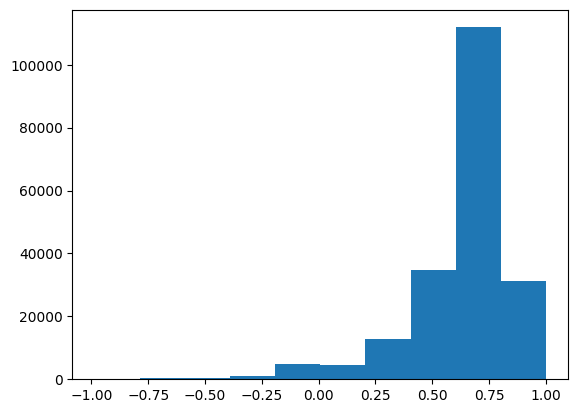

In [15]:
# Step 4: Assign the "Recommendation" based on the 'median_score' column
result_df['Recommendation'] = result_df['median_score'].apply(lambda score: 'Recommended' if score > 0.75 else 'Not Recommended')

# Display the result_df with the additional columns
plt.hist(result_df['median_score'])

#### Writing data to snowflake tables

In [ ]:
#Use snowflake session "conn"
no_duplicates_df_sf = conn.createDataFrame(no_duplicates_df)
#Writing data to snowflake
no_duplicates_df_sf.write.mode('overwrite').save_as_table('BEAUTY_PRODUCT_REVIEWS')

In [ ]:
# Upload the processed dataframes to snowflake tables
conn.createDataFrame(emotion_df).write.mode('overwrite').save_as_table('EMOTIONS_OVERALL')
conn.createDataFrame(emotion_df_merge).write.mode('overwrite').save_as_table('EMOTIONS')
conn.createDataFrame(category_time).write.mode('overwrite').save_as_table('CATEGORY_ANALYSIS')

In [ ]:
#Upload recommendations to snowflake table
columns_to_extract = ['brand', 'title', 'Category', 'median_score', 'Recommendation']
recommendation_table = result_df[columns_to_extract]
conn.createDataFrame(recommendation_table).write.mode('overwrite').save_as_table('RECOMMENDATIONS')


In [ ]:
# Upload sentiment trends table to snowflake 
columns_to_extract = ['Date', 'reviewText', 'title', 'brand', 'Vader Sentiment', 'Vader Analysis', 'Category']
st_tl_table=no_duplicates_df[columns_to_extract]
conn.createDataFrame(st_tl_table).write.mode('overwrite').save_as_table('SENTIMENT_TRENDS')